In [1]:
import torch
DATA = 'CIFAR'
prefix = 'cifar_bnn_'
traing = True
epochs = 400
batch_size = 64
leaks_loss = None
print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


In [2]:
import os
from google.colab import drive

drive.mount('/content/gdrive')
root_path = '/content/gdrive/MyDrive/Colab Notebooks/BinarizeLocalize/'

Mounted at /content/gdrive


In [3]:
pip install import-ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp37-none-any.whl size=2976 sha256=db8756ff16c1b1a659278b4e4852271437f554c4c6f4009feea124ed450def93
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [4]:
import import_ipynb
os.chdir(root_path + 'library')
Call_Template = True
%run Template.ipynb

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


##Fetching the dataset and preparing train, validation and test data loaders

In [5]:
(trainSet, validSet, checkSet, testSet,
 trainSetGPU, validSetGPU, checkSetGPU) = load_data_to_gpu()
print(len(trainSet), len(validSet), len(checkSet), len(testSet))

Files already downloaded and verified
Files already downloaded and verified



50000 7000 3000 10000


##Visualising the data

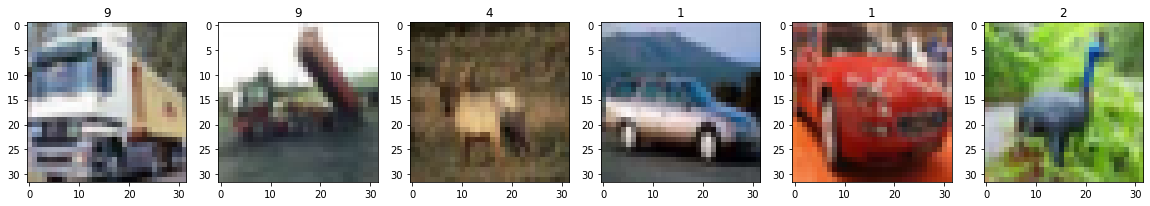

In [6]:
plot_samples(trainSet, None)

In [7]:
class Network(Model):
    def __init__(self):
        super(Network, self).__init__()
        # at client
        self.feature0 = nn.Sequential(
            BinaryConv2d(3, 64, 3, 1, 1), #32
            nn.BatchNorm2d(64),
            BinaryTanh(),
        )
        self.feature1 = nn.Sequential(
            nn.MaxPool2d(2), #16
            nn.Dropout(0.1),
        )
        # at server
        self.feature2 = nn.Sequential(
            BinaryConv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            BinaryTanh(),
            nn.MaxPool2d(2), #8
            nn.Dropout(0.2),
            
            BinaryConv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            BinaryTanh(),
            nn.Dropout(0.2),
            
            BinaryConv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            BinaryTanh(),
            nn.MaxPool2d(2), #4
            nn.Dropout(0.2),
            
            BinaryConv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            BinaryTanh(),
            nn.Dropout(0.2),

            BinaryConv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            BinaryTanh(),
            nn.MaxPool2d(2), #2
            nn.Dropout(0.2),

            BinaryConv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            BinaryTanh(),
            nn.Dropout(0.2),

            BinaryConv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            BinaryTanh(),
            nn.MaxPool2d(2), #1
            nn.Dropout(0.2),
        )
        self.classifier = nn.Sequential(
            BinaryLinear(1 * 512, 4096),
            nn.BatchNorm1d(4096),
            BinaryTanh(),
            nn.Dropout(0.3),
            BinaryLinear(4096, 1000),
            nn.BatchNorm1d(1000),
            BinaryTanh(),
            nn.Dropout(0.2),
            BinaryLinear(1000, 10)
        )

##Defining model object, loss function and optimiser

In [8]:
(model, criterion, dataleaks, optimizer) = init_training(Network(), 0.0001)

##Training and Validation

In [9]:
(trainLoss, validLoss, leaksLoss, accuracyList) = train_model(2)

RuntimeError: ignored

In [ ]:
(model, trainLoss, validLoss, leaksLoss, accuracyList) = save_and_load()

In [ ]:
plot_losses()

In [ ]:
test_model()

##Measuring Privacy Preserving

In [ ]:
plot_measure(measure_image(testSet[1][0]))

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()